# Coursework 2 QRM

### Q1 part A: Fitting a GARCH(1,1) model to the trainning data

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import scipy.stats as ss
import statsmodels.api as sm #For acf plots
from arch.univariate import arch_model #We import the arch package to fit the time series model
from scipy.stats import skew, kurtosis, norm,t # to use the generalised Student-t pdf
from scipy.optimize import minimize #import minimize function from SciPy
#We upload the data
TSLAdata = pd.read_csv(r'C:\Users\Alberto\Documents\0 UNIVERSIDAD\MSC Imperial\QUANTITATIVE RISK MANAGEMENT\COURSEWORK 2\QRM-2022-cw2-data.csv')
TSLAdata['Date'] = pd.to_datetime(TSLAdata['Date'])
TSLAdata.sort_values(by='Date', ascending=True)
TSLAdata.set_index('Date', inplace=True)

#We create the simple and log returns in our panda frame
TSLAdata['simplereturn'] = TSLAdata['TSLA'].pct_change()
TSLAdata['logreturn'] = np.log(TSLAdata['TSLA']).diff()
#TSLAdata['logreturn'] = np.log(1 + TSLAdata['simplereturn'])

# Multiply the return values by 100 so they represent percentage values
TSLAdata['simplereturn']  = TSLAdata['simplereturn']  * 100
TSLAdata['logreturn'] = TSLAdata['logreturn'] * 100

#Calculation of parameters asked
mu = TSLAdata['logreturn'].mean()
sigma = TSLAdata['logreturn'].std()

TSLAdata.head()

# Select DataFrame rows between two dates
start_date_train = '2012-11-26'
end_date_train   = '2021-11-25'
TSLAdata_train = TSLAdata.query('Date >= @start_date_train and Date <= @end_date_train')

start_date_test = '2021-11-26'
end_date_test   = '2022-11-26'
TSLAdata_test = TSLAdata.query('Date >= @start_date_test and Date <= @end_date_test')

garchmodel = arch_model(TSLAdata['logreturn'].dropna(), mean='constant', rescale= 'True', p=1, q=1, dist='normal')
resgarch = garchmodel.fit(update_freq=5)
print(resgarch.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 6895.1504409974
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6571.569532847754
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6571.568723403154
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              logreturn   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6571.57
Distribution:                  Normal   AIC:                           13151.1
Method:            Maximum Likelihood   BIC:                           13174.5
                                        No. Observations:                 2518
Date:                Fri, Dec 02 2022   Df Residuals:                     2517
Time:            

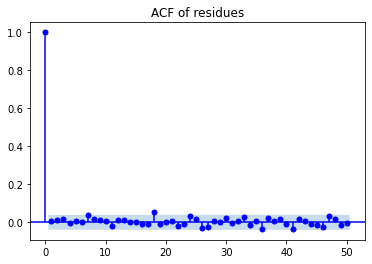

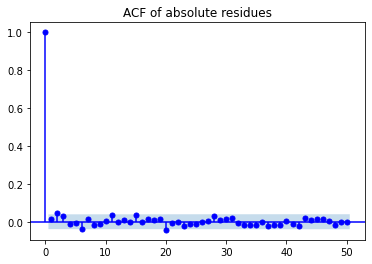

0.007521575290248952
0.9997464802212903


In [4]:
my_color = 'b'
sm.graphics.tsa.plot_acf(resgarch.std_resid, lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of residues")
plt.show()
sm.graphics.tsa.plot_acf(np.abs(resgarch.std_resid).dropna(), lags=50,color=my_color, vlines_kwargs={"colors": my_color},
                         title="ACF of absolute residues")
plt.show()

print(resgarch.std_resid.mean())
print(resgarch.std_resid.std())

The hypothesis of independent seems feasible enough

### Q1 part B: Fitting a normalised student t-distribution

As another exercise, let's fit a student normalised distribution to $(Z_t)_t$. A **normalised Student-t distribution** with degree of freedom $\nu$ and **unit variance**, which pdf is $$f_Z(z)=f_{general-t-dist}\left(z;\text{df}=\nu,\text{location}=0,\text{scale}=\sqrt{\frac{\nu-2}{\nu}}\right)$$ where $f_{general-t-dist}$ is the pdf of a generalised t distribution with degree of freedom $\nu$ and some location and scale parameter.

REMARK: a standard Student-t distribution with degree of freedom $\nu$ has variance $\nu/(\nu-2)$ but not one. If $Y$ is a standard Student-t distribution, we need to construct $Z$ in form of $Z=\sqrt{\frac{\nu-2}{\nu}} Y$ to enforce $var(Z)=1$. Hence $Z$ can be thought as a general t-distribution with location parameter of zero and scale parameter of $\sqrt{\frac{\nu-2}{\nu}}$.

We will use (log-)maximum likelihood for this purposes:

In [115]:
#This is just an attempt to use a package, it does not seem to work
from scipy import stats
dist = getattr(stats, 't')
parameters = dist.fit(resgarch.std_resid.dropna())
print(parameters)

student_fittet = parameters[0]*


(3.733591881428594, 0.015436259447195327, 0.7028807797475118)


3.733591881428594

In [ ]:
#Requires the distribution t previously loaded
def log_likelihood_function_t(nu, x):
    return np.sum(np.log(t.pdf(x[1:], nu, 0, np.sqrt((nu-2)/nu)) ) ) 

objfun_loglikelihood_t = lambda y : -1 * log_likelihood_function_t(y, resgarch.std_resid.dropna())

y0 = 2.1

print("Initial objective function value: " + str(objfun_loglikelihood_t(y0)))
bnds = (0,np.inf)
con = {'type': 'ineq'} 

sol_loglikelihood = minimize(objfun_loglikelihood_t, y0 ,method='SLSQP',bounds=bnds, options={'disp': True})

print("Estimate of nu: " + str(sol_loglikelihood.x[0]))
print("Solution->",sol_loglikelihood)

Once the parameter of degreees of freedom is obtained we simply draw a histogram and qqplots with that student t and see if it is a good fit.

### Q1 part C: generalised Pareto distribution (GPD)

In [110]:
TSLAdata['std_residuals'] = resgarch.std_resid
TSLAdata

,TSLA,simplereturn,logreturn,std_residuals
Date,,,,
2012-11-26,2.151333,NaN,NaN,NaN
2012-11-27,2.143333,-0.371862,-0.372556,-0.270666
2012-11-28,2.215333,3.359254,3.304064,1.737641
2012-11-29,2.246000,1.384307,1.374813,0.647968
2012-11-30,2.254667,0.385886,0.385143,0.134838
...,...,...,...,...
2022-11-18,180.190002,-1.626902,-1.640281,-0.458074
2022-11-21,167.869995,-6.837231,-7.082202,-1.901933
2022-11-22,169.910004,1.215231,1.207907,0.271843


Text(0.5, 0, '$v$')

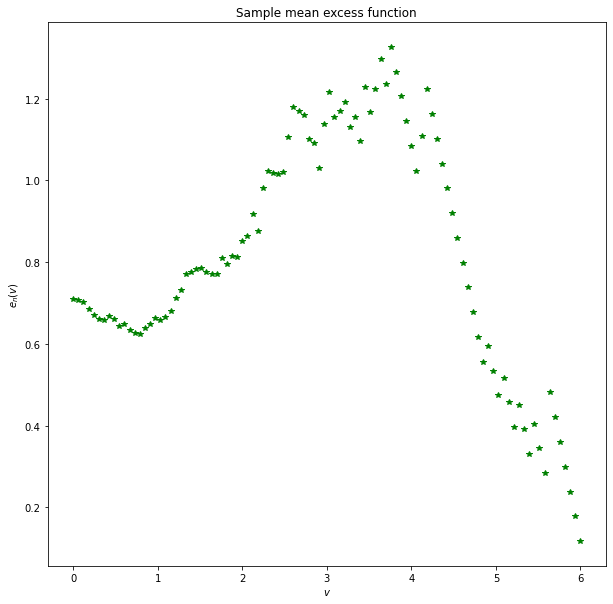

In [133]:
v = np.linspace(0, 6, 100) # some values of v
excess_mean = []

for vv in v:
    excess_mean.append(np.sum((resgarch.std_resid - vv) * (resgarch.std_resid > vv)) / np.sum(resgarch.std_resid > vv))
plt.figure(figsize = (10,10))
plt.plot(v, excess_mean, 'g*')
plt.title("Sample mean excess function")
plt.ylabel("$e_n(v)$")
plt.xlabel("$v$")

In [134]:
u = 1.2 # our choice of u
y = TSLAdata[TSLAdata['std_residuals'] > u]['std_residuals'] - u # construction of y
print(y)

Date
2012-11-28    0.537641
2013-01-02    0.796832
2013-01-24    0.010480
2013-01-28    0.041818
2013-02-19    1.389786
                ...   
2022-07-29    0.175277
2022-10-17    0.551648
2022-10-25    0.098821
2022-11-10    0.593849
2022-11-23    0.695977
Name: std_residuals, Length: 212, dtype: float64


In [135]:
def GPD_loglikelihood(y, xi, beta):
    return -len(y) * np.log(beta) - (1 + 1/xi) * np.sum(np.log(1 + xi * y / beta))

objfun = lambda theta : -1 * GPD_loglikelihood(y, theta[0], theta[1]) # theta[0] represents xi and theta[1] represents beta

theta0 = [1, 1]  # initial guess
print("Initial objective function value: " + str(objfun(theta0)))

bnds = ((0.01,20), (0,20)) # individual bound on each parameter

sol = minimize(objfun,theta0,method='SLSQP',bounds=bnds, options={'disp': True})

print("Estimate of xi: " + str(sol.x[0]))
print("Estimate of beta: " + str(sol.x[1]))

Initial objective function value: 187.7620915120299
Optimization terminated successfully    (Exit mode 0)
            Current function value: 130.49302078795068
            Iterations: 13
            Function evaluations: 48
            Gradient evaluations: 13
Estimate of xi: 0.20890417063263092
Estimate of beta: 0.5524209788865124


C:\Users\Alberto\AppData\Local\Temp/ipykernel_2164/2961284349.py:2: RuntimeWarning: divide by zero encountered in log
  return -len(y) * np.log(beta) - (1 + 1/xi) * np.sum(np.log(1 + xi * y / beta))
C:\Users\Alberto\AppData\Local\Temp/ipykernel_2164/2961284349.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return -len(y) * np.log(beta) - (1 + 1/xi) * np.sum(np.log(1 + xi * y / beta))


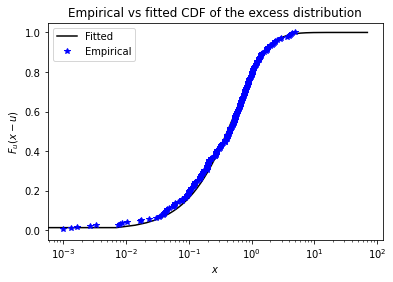

In [136]:
def GPD_cdf(x, xi, beta): # Implement the CDF of GPD
    if xi == 0:
        return 1 - np.exp(-x/beta)
    else:
        return 1 - (1 + xi * x / beta) ** (-1/xi)

xx = np.linspace(0, 70, 10000) # For plotting the theoretical, fitted GPD

# Empirical CDF functionality from the "statsmodels" package
empirical_cdf_obj = sm.distributions.empirical_distribution.ECDF((y.to_numpy()).flatten()) 

fig, ax = plt.subplots()
ax.plot(xx, GPD_cdf(xx, sol.x[0], sol.x[1]), 'k-', label='Fitted') # Plot the CDF of fitted GPD
ax.plot(y, empirical_cdf_obj(y), 'b*', label='Empirical') # Plot the empirical CDF of Y, the excess claim value above u
ax.legend()
ax.set_xscale('log')
ax.set_title('Empirical vs fitted CDF of the excess distribution')
ax.set_ylabel('$F_{u}(x-u)$')
ax.set_xlabel('$x$')
plt.show()

### Q1 part D: computing VaR and ES forecasts.

Compute several sets of VaR and ES forecast on each date in the testing data
set at 95% and 99% confidence levels, based on the following different specifications
of the strict white noise component Z in the GARCH(1,1)model: \ \
I Z follows a standard normal distribution; \ \
I Z follows a normalised Student t distribution; \ \
I Z is such that its excess distribution (over u) is described by GPD. \ \
Describe clearly how you compute the VaR and ES under each specification.
Display the risk forecasts graphically. Backtest the VaR forecasts by considering
unconditional coverage tests only and compare the results under different
specifications.